Will look at multi-label classification and regression here. The data will be the PASCAL dataset, which can have more than one kind of classified object per image.

In [3]:
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)

This dataset comes with a CSV file telling us what labels to use for each image. Can inspect the CSV file by reading it into a DataFrame:

In [4]:
df = pd.read_csv(path/'train.csv')

df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


# Constructing a DataBlock

Need to go from a `DataFrame` object to a `DataLoaders` object. Typically want to do this using the datablock API for creating a `DataLoaders` object.

PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

* `Dataset`: Collection that returns a tuple of your two variables.
* `DataLoader`: Iterator that provides a stream of mini-batches, where each mini-batch is a tuple batch of indep. and dep. vars.

Also have two fastai classes to bring training and validation sets together:

* `Datasets`: An object that contains a training `Dataset` and a validation `Dataset`.
`DataLoaders`: An object that contains a training `DataLoader` and a validation `DataLoader`.

Typically easiest to create and test `Datasets`, then look at `DataLoaders` once that works.

Create a `DataBlock` gradually and check each step:

In [5]:
# Create a data block with no parameters:

dblock = DataBlock()

In [6]:
# Create a Datasets object from this using the DataFrame
# as the source:

dsets = dblock.datasets(df)

In [7]:
# Can index into the training and validation datasets:

len(dsets.train), len(dsets.valid)

(4009, 1002)

In [8]:
x, y = dsets.train[0]

x, y

(fname           006664.jpg
 labels      bicycle person
 is_valid              True
 Name: 3355, dtype: object,
 fname           006664.jpg
 labels      bicycle person
 is_valid              True
 Name: 3355, dtype: object)

To get the fields we need from the DataFram, can use `get_x` and `get_y` functions:

In [9]:
from fastai.callback.fp16 import *

dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('003466.jpg', 'person diningtable pottedplant')

Rather than defining a function in the usual way, we are using Python's `lambda` keyword. This is just a shortcut for defining and then referring to a function. The following more verbose approach is identical:


```python
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]
```

Lambda functions are great for quickly iterating, but they are not compatible with serialization, so we advise you to use the more verbose approach if you want to export your `Learner` after training (lambdas are fine if you are just experimenting).

Independent variable needs to be converted into a complete path so we can open it as an image.

Dependent variable needs to be split on the space character (use `split` function for this) so it becomes a list:

In [10]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/000373.jpg'), ['car'])

To open the image and convert to tensors, need to use a set of transforms; block types will provide us with those.

Will use `ImageBlock` and `MultiCategoryBlock`:

In [11]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]


(PILImage mode=RGB size=500x335,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 1., 0.]))

Here we have a list of zeros, with a one in any position where that category is present. For example, if there is a one in the second and fourth positions, then that means that vocab items two and four are present in this image.

Check what the categories represent in this example using `torch.where`:

In [12]:
idxs = torch.where(dsets.train[0][1]==1.)[0]

dsets.train.vocab[idxs]

(#2) ['person','train']

Ignored the `is_valid` column up until now, so `DataBlock` has been using a random split. To specify a specific split in the validation set, need to write a function and pass it to `splitter`:

In [13]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

Making each item is the same size:

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

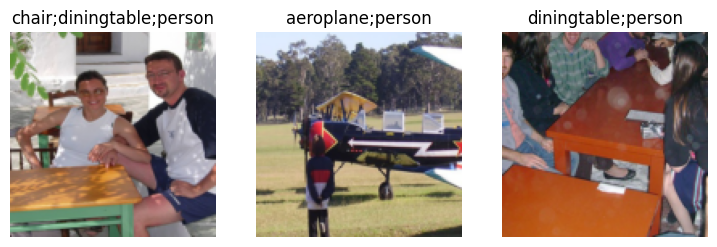

In [15]:
# Display sample of data

dls.show_batch(nrows=1, ncols=3)

In [16]:
# Use vision_learner to create a Learner to look at its activations:

learn = vision_learner(dls, resnet18)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.2MB/s]


In [17]:
# Try grabbing a mini batch from our DataLoader and pass it to the model:

x, y = to_cpu(dls.train.one_batch())

activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [18]:
activs[0]

TensorImage([ 2.1353,  3.5261, -3.3431,  1.1319,  3.4137,  3.9894, -3.8126,
             -0.9280, -4.5037, -3.9569,  3.0442,  1.9439, -3.8565,  3.0732,
             -0.6328, -0.8242, -3.6175,  0.4454,  5.3802,  1.4968],
            grad_fn=<AliasBackward0>)

In [19]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [21]:
# Can do this same thing with a build-in function:

# Can use BCEWitLogitLoss since we have a one-hot-encoded target:


loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TypeError: ignored

In [22]:
# Find thresholds of what to consider 0s and what to consider 1s:

def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "Compute accuracy when 'inp' and 'targ' are the same size."

  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [23]:
# Train model with an accuracy hreshold of 0.2 for our metric:

learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi,
                                                      thresh=0.2))

learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941813,0.700205,0.226833,10:53
1,0.823805,0.554872,0.286494,11:13
2,0.602744,0.200281,0.820618,11:23


KeyboardInterrupt: ignored

Important to pick a threshold.

If you pick a threshold that's too low, you'll often be failing to select correctly labeled objects.

Can see this by changing our metric, then calling `validate`, which resturns the validation loss and metrics:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)

learn.validate()

Pick a threshold that's too high, only select the object that the model is really confident about:

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)

learn.validate()

Best way to find the threshold is to try a few and see what works best:

In [ ]:
preds, targs = learn.get_preds()

Call the metric directly, but don't apply the output activation function:

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)

accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

# Regression

A model is just defined by its independent and dependent variables. They don't need to be the same type.

We could have an independent variable that's an image, and a dependent variable that's text, or vice versa.

We're going to do a *key point* model here, which is a specific location represented in an image, like the center of a person's face. This mean's we're using two values for each image: the row and column of the face center.

## Assemble the Data

In [27]:
path = untar_data(URLs.BIWI_HEAD_POSE)

AttributeError: ignored

In [25]:
path.ls().sorted()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/valid.json')]

In [26]:
(path/'01').ls().sorted # look inside one of the directories

FileNotFoundError: ignored

In [ ]:
# get image files with get_image_files and convert it to a thumbnail:

img_files = get_image_files(path)

def img2pose(x): return Path(f'{str(x)[:7]}pose.txt')

img2pose(img_files[0])

In [ ]:
im = PILImage.create(img_files[0])
im.shape

In [ ]:
im.to_thumb(160)

In [ ]:
# Code to extract the head center point:

cal = np.getfromtxt(path/'01'/'rgb.cal', skip_footer=6)

def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)

  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]

  return tensor([c1, c2])

In [ ]:
get_ctr(img_files[0])

Don't want to use a random splitter since the same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people it hasn't seen yet.

Want a splitter function that returns true for just one person, resulting in a validation set containing just that persons images.

Want to include a `PointBlock` as the second block so that fastai knows that the labels represent coordinates.

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=aug_tramsforms(size=(240,320))
)

In [ ]:
# Make sure data looks okay:

dls = biwi.dataloaders(path)

dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
# Also want to look at the underlying tensors, especially as a student:

xb, yb = dls.one_batch()

xb.shape, yb.shape

Didn't need to use a separate image regression application. We just labeled the data and told fastai what kind of data the independent and dependent variables represent.

Same thing for creating our `Learner`. Use the same function as before, with one new parameter, and then we'll train it:

## Training a Model

In [ ]:
learn = vision_learner(dls, resnet18, y_range=(-1, 1))

In [ ]:
# Find a good learning rate with the lr finder:

learn.lr_find()

In [ ]:
# Try an LR of 1e-2:

lr = 1e-2

learn.fine_tune(3, lr)

In [ ]:
# Look at the results to make sure our actual coordinates (left) are similar to
# the model's predictions (right):

learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))